In [1]:
#coding=utf-8
import os
!python --version
!pwd
suffix=os.path.split(os.getcwd())[-1]
!ls -l test.dat.{suffix}
!ls -l train.dat.{suffix}
!wc -l test.dat.{suffix}
!wc -l train.dat.{suffix}
!head -n 1 train.dat.202508261937 | awk -F ',' '{print "train NF",NF}'
!head -n 1 test.dat.202508261937  | awk -F ',' '{print "test NF",NF}'
!ls

Python 3.7.5
/d/GH/GitWorkSpace/bank_model_competiton/data/202508261937
-rw-r--r-- 1 chenchen 197121 4919269 Aug 27 00:32 test.dat.202508261937
-rw-r--r-- 1 chenchen 197121 13451760 Aug 27 00:30 train.dat.202508261937
20055 test.dat.202508261937
53481 train.dat.202508261937
train NF 38
test NF 37
202508261937_gh_lgb_kfold_v1.csv
202508261937_gh_lgb_kfold_v1_full.txt
202508261937_gh_lgb_v3.csv
202508261937_gh_v1.csv
202508261937_gh_v2.csv
model_lgb_kfold_v5.3.ipynb
model_lgb_v5.2.ipynb
model_stacking_v5.0.ipynb
model_stacking_v5.1.ipynb
model_stacking_v5.ipynb
process_v5.ipynb
test.dat.202508261937
train.dat.202508261937


In [3]:
# -*- coding: utf-8 -*-
from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
import pandas as pd
import xgboost as xgb
import datetime
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split
import sys
import os
import time 
import matplotlib as plt 
import seaborn as sns
from lightgbm import log_evaluation, early_stopping
import random
from sklearn.model_selection import StratifiedKFold


suffix = os.path.split(os.getcwd())[-1]

train_dat_path = "train.dat.%s" % suffix 
test_dat_path = "test.dat.%s"  % suffix 
print(train_dat_path, test_dat_path, suffix)
print('process time : ',time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime()))

train.dat.202508261937 test.dat.202508261937 202508261937
process time :  2025-08-30 16:29:50


# GBDT MODE

In [4]:
def gbdt_model(X_train, y_train, X_test, y_test=None):
    model = GradientBoostingClassifier(learning_rate = 0.02, 
                                       max_features = 0.7, 
                                       n_estimators = 700, 
                                       verbose = 1,
                                       max_depth = 5).fit(X_train,y_train)
    predict = model.predict_proba(X_test)[:,1]
    minmin = min(predict)
    maxmax = max(predict)
    vfunc = np.vectorize(lambda x:(x-minmin)/(maxmax-minmin))
    return model, vfunc(predict)

def gbdt_model2(X_train, y_train, X_test, y_test=None):
    model = GradientBoostingClassifier(learning_rate = 0.02, 
                                       max_features = 0.7, 
                                       n_estimators = 200,    
                                       n_iter_no_change = 20,
                                       validation_fraction=0.1,
                                       verbose = 1,
                                       max_depth = 5).fit(X_train, y_train, monitor = None)
    predict = model.predict_proba(X_test)[:,1]
    minmin = min(predict)
    maxmax = max(predict)
    vfunc = np.vectorize(lambda x:(x-minmin)/(maxmax-minmin))
    return model, vfunc(predict)

# 特征重要性分析

In [139]:
#lgb model
df_imp = pd.DataFrame([ lgb_cate_clf.feature_name(), lgb_cate_clf.feature_importance(), lgb_cate_clf.feature_importance(importance_type='gain')]).T
df_imp.sort_values(by=2,ascending=False)

,0,1,2
2,zip_code,1691,67135.364557
6,interest_rate,391,15652.035131
5,term,136,13450.074903
10,record_time,230,7756.683848
19,interest_rate_log,174,6504.653823
7,issue_time,285,5580.269274
13,balance_accounts,171,5421.071142
32,0_amount_avg2,97,5083.4072
29,0_amount_avg,77,2685.896425
14,balance_limit,107,2634.643231


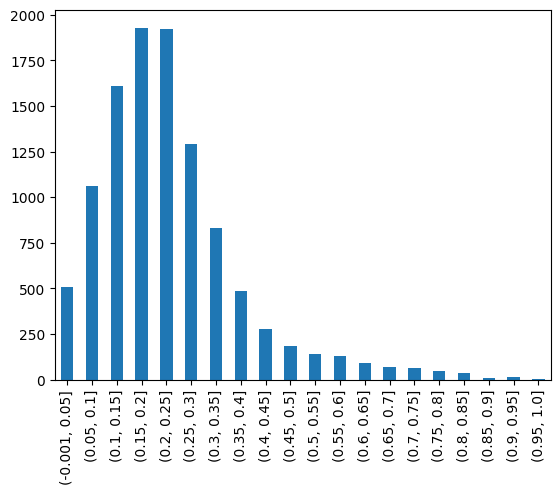

In [15]:
def stat_result(pp_ret):
    ret = pd.DataFrame({'label' : pp_ret})
    df_ret = ret.groupby(pd.cut(pp_ret, bins=20))['label'].agg('count')
    df_ret.plot(kind='bar')
    
stat_result(lgb_pred)

In [44]:
# gdb model
feature_importance = model.feature_importances_
# print(feature_importance)
# print(model.feature_names_in_ )
df_fea_importance = pd.DataFrame({'feat': model.feature_names_in_ , 'feat_importances' : model.feature_importances_ })
pd.set_option('display.max_rows', 100)

df_fea_importance.sort_values(by='feat_importances',ascending=False)

,feat,feat_importances
10,record_time,0.075398
5,term,0.069389
19,interest_rate_log,0.067587
6,interest_rate,0.065451
7,issue_time,0.063232
15,balance,0.044945
13,balance_accounts,0.043757
14,balance_limit,0.042163
11,history_time,0.042011
32,0_amount_avg2,0.040164


<AxesSubplot:>

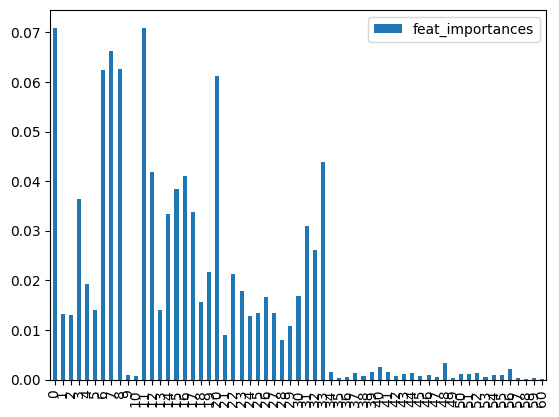

In [42]:
# plt.figure(figsize=(10, 6))
# sns.barplot(x='feat_importances', y='feat', data=df_fea_importance)
# df_fea_importance.plot(kind='bar')
# plt.set_title('Feature Importance')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.show()

# KFold Begin

In [5]:
from sklearn.model_selection import StratifiedKFold

dummy_fea = ['id', 'level']
train_data = pd.read_csv(train_dat_path, engine = 'python');
test_data  = pd.read_csv(test_dat_path, engine = 'python');

train_test_data = pd.concat([train_data, test_data], axis=0,    ignore_index = True)
train_test_data.drop(['tx_time_max', 'tx_time_min'], axis=1, inplace=True)
train_test_data = train_test_data.fillna(0)
train_test_data.replace([np.inf, -np.inf], 0, inplace=True)

dummy_df = pd.get_dummies(train_test_data.loc[:,dummy_fea])
train_test_data = pd.concat([train_test_data, dummy_df], axis=1)
train_test_data = train_test_data.drop(dummy_fea, axis=1)
print(train_test_data)

train_train = train_test_data.iloc[:train_data.shape[0],:]
test_test = train_test_data.iloc[train_data.shape[0]:,:]

y_train_train = train_train['label'].values
X_train_train = train_train.drop(['label'], axis=1)
y_test_test  = test_test['label'].values
X_test_test  = test_test.drop(['label'], axis=1)


       title  career  zip_code  residence   loan  term  interest_rate  \
0          9     0.0    221373          1   7200    36          10.95   
1          8    10.0    311681          0  21300    36          12.95   
2          8     7.0    271562          1  10400    60          21.05   
3          7     2.0    522083          0  33050    36          16.40   
4          8     3.0    101026          1   5200    36          14.35   
...      ...     ...       ...        ...    ...   ...            ...   
73529      0     8.0    601107          1  10000    12          18.85   
73530      0    10.0    601102          1  10000    12          29.30   
73531      0     4.0    601408          1  11000    12          24.75   
73532      0     3.0    601904          1   8000    12          22.00   
73533      2     1.0    601809          1   7000    12          14.95   

       issue_time  syndicated  installment  ...  level_D1  level_D2  level_D3  \
0      1238631967           0            1

# GBDT model_11 SKFold

In [12]:
def gbdt_model_11(X_train, y_train, X_test, y_test=None):
    model = GradientBoostingClassifier(learning_rate = 0.02, 
                                       max_features = 0.7, 
                                       n_estimators = 1000, 
                                       n_iter_no_change = 100,
                                       validation_fraction=0.1,
                                       verbose = 1,
                                       max_depth = 5).fit(X_train,y_train)
    predict = model.predict_proba(X_test)[:,1]
    minmin = min(predict)
    maxmax = max(predict)
    vfunc = np.vectorize(lambda x:(x-minmin)/(maxmax-minmin))
    return model, vfunc(predict)

# --------------------------------------------------------------------------------- #

n_folds = 5
answers = []
auc_arr = [] 

sk = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=10)
y_train_train = pd.DataFrame(y_train_train)
for i, (train, test) in enumerate(sk.split(X_train_train, y_train_train)):
    X_train = X_train_train.iloc[train]
    y_train = y_train_train.iloc[train]
    X_test  = X_train_train.iloc[test]
    y_test  = y_train_train.iloc[test]
    #gdb model 
    gdb_clf, test_pred = gbdt_model_11(X_train, y_train, X_test, y_test)
    train_pred = gdb_clf.predict_proba(X_train)[:,1]
    # 记录训练集auc, 测试集auc
    train_auc = roc_auc_score(y_train, train_pred)
    test_auc  = roc_auc_score(y_test, test_pred)
    
    print('--------------the %d epoch gbd_model valid auc ------------- ' % i , train_auc, test_auc)
    auc_arr.append((train_auc,test_auc))
    #最终输出
    final_pred = gdb_clf.predict_proba(X_test_test)[:,1]
    print('final pred ',final_pred)
    answers.append(final_pred)
print('auc arr \n', pd.DataFrame(auc_arr))
print('auc describe \n', pd.DataFrame(auc_arr).describe())

d:\users\chenchen\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.9552            3.54m
         2           0.9531            3.69m
         3           0.9510            3.60m
         4           0.9491            3.80m
         5           0.9471            3.79m
         6           0.9452            3.84m
         7           0.9436            3.88m
         8           0.9418            3.94m
         9           0.9401            4.08m
        10           0.9387            4.14m
        20           0.9257            4.07m
        30           0.9164            4.03m
        40           0.9097            4.01m
        50           0.9041            3.95m
        60           0.8994            3.89m
        70           0.8952            3.83m
        80           0.8918            3.76m
        90           0.8887            3.68m
       100           0.8861            3.64m
       200           0.8664            3.33m
       300           0.8529            2.98m
---------

d:\users\chenchen\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.9553            5.28m
         2           0.9530            5.86m
         3           0.9508            5.50m
         4           0.9486            5.34m
         5           0.9468            5.26m
         6           0.9449            5.12m
         7           0.9431            4.97m
         8           0.9413            4.89m
         9           0.9399            4.81m
        10           0.9383            4.84m
        20           0.9251            4.68m
        30           0.9156            4.51m
        40           0.9086            4.41m
        50           0.9029            4.29m
        60           0.8985            4.33m
        70           0.8949            4.22m
        80           0.8917            4.16m
        90           0.8887            4.08m
       100           0.8864            4.03m
       200           0.8673            3.56m
       300           0.8516            3.20m
---------

d:\users\chenchen\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.9553            4.62m
         2           0.9534            5.17m
         3           0.9514            5.24m
         4           0.9495            5.18m
         5           0.9477            5.10m
         6           0.9460            4.99m
         7           0.9443            5.11m
         8           0.9426            5.02m
         9           0.9407            4.91m
        10           0.9392            4.77m
        20           0.9259            4.40m
        30           0.9161            4.20m
        40           0.9086            4.11m
        50           0.9025            4.01m
        60           0.8976            3.94m
        70           0.8935            3.88m
        80           0.8900            3.82m
        90           0.8871            3.79m
       100           0.8846            3.75m
       200           0.8667            3.42m
       300           0.8524            3.06m
       40

d:\users\chenchen\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.9554            4.24m
         2           0.9534            4.26m
         3           0.9515            4.20m
         4           0.9494            4.08m
         5           0.9476            4.03m
         6           0.9456            4.00m
         7           0.9440            4.04m
         8           0.9421            4.06m
         9           0.9406            4.04m
        10           0.9390            3.99m
        20           0.9265            3.98m
        30           0.9166            3.99m
        40           0.9095            3.92m
        50           0.9036            3.85m
        60           0.8986            3.85m
        70           0.8944            3.82m
        80           0.8909            3.78m
        90           0.8878            3.76m
       100           0.8851            3.73m
       200           0.8665            3.35m
       300           0.8528            2.98m
---------

d:\users\chenchen\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.9554            5.28m
         2           0.9531            5.16m
         3           0.9511            4.94m
         4           0.9493            4.97m
         5           0.9475            4.96m
         6           0.9455            4.83m
         7           0.9436            4.71m
         8           0.9419            4.61m
         9           0.9402            4.65m
        10           0.9387            4.73m
        20           0.9260            4.41m
        30           0.9161            4.23m
        40           0.9086            4.16m
        50           0.9028            4.04m
        60           0.8981            3.97m
        70           0.8941            3.87m
        80           0.8902            3.78m
        90           0.8872            3.71m
       100           0.8840            3.65m
       200           0.8643            3.26m
       300           0.8499            2.87m
       40

# GBDT model1 指定种子 

In [36]:
#gbde model 1

answers = []
auc_arr = [] 

# for seed in  [10, 11, 100, 1000, 2025, 1989]:
# for seed in  [10, 11, 1989]:
for i, seed in  enumerate([10, 11, 1989]):
    X_train, X_test, y_train, y_test = train_test_split(X_train_train, y_train_train, test_size=0.2, random_state=seed, shuffle=True)
    #gdb model 
    gdb_clf, test_pred = gbdt_model(X_train, y_train, X_test, y_test)
    train_pred = gdb_clf.predict_proba(X_train)[:,1]
    # train auc, test auc
    train_auc = roc_auc_score(y_train, train_pred)
    test_auc  = roc_auc_score(y_test,  test_pred)
    print('-----------------------------the %d epoch gdb_model valid auc --------------------- ' % i, train_auc, test_auc)
    auc_arr.append((train_auc, test_auc))
    #最终输出
    final_pred = gdb_clf.predict_proba(X_test_test)[:,1]
    print('final pred ',final_pred)
    answers.append(final_pred)
print('auc arr \n', pd.DataFrame(auc_arr, columns=['train auc', 'test_auc']))
print('auc desccribe \n', pd.DataFrame(auc_arr).describe())
print('answers ', np.array(answers).shape)

      Iter       Train Loss   Remaining Time 
         1           0.9561            2.91m
         2           0.9540            2.75m
         3           0.9521            2.78m
         4           0.9501            2.72m
         5           0.9483            2.80m
         6           0.9464            2.78m
         7           0.9445            2.75m
         8           0.9429            2.81m
         9           0.9412            2.82m
        10           0.9396            2.82m
        20           0.9270            2.93m
        30           0.9178            2.92m
        40           0.9113            2.88m
        50           0.9062            2.75m
        60           0.9017            2.65m
        70           0.8980            2.57m
        80           0.8949            2.50m
        90           0.8921            2.45m
       100           0.8893            2.40m
       200           0.8713            1.97m
       300           0.8570            1.59m
       40

# GBDT model1 随机种子

In [39]:
answers = []
auc_arr = [] 
random.seed(a=10)
seed_arr = random.sample(range(1,10000), 5)
# for seed in  [10, 11, 100, 1000, 2025, 1989]:
# for seed in  [10, 11, 1989]:
for i, seed in enumerate(seed_arr):
    X_train, X_test, y_train, y_test = train_test_split(X_train_train, y_train_train, test_size=0.2, random_state=seed, shuffle=True)
    #gdb model 
    gdb_clf, test_pred = gbdt_model(X_train, y_train, X_test, y_test)
    train_pred = gdb_clf.predict_proba(X_train)[:,1]
    # train auc, test auc
    train_auc = roc_auc_score(y_train, train_pred)
    test_auc  = roc_auc_score(y_test,  test_pred)
    print('-----------------------------the %d epoch gdb_model valid auc --------------------- ' % i , train_auc, test_auc)
    auc_arr.append((train_auc, test_auc))
    #最终输出
    final_pred = gdb_clf.predict_proba(X_test_test)[:,1]
    print('final pred ',final_pred)
    answers.append(final_pred)
print('auc arr \n', pd.DataFrame(auc_arr, columns=['train auc', 'test_auc']))
print('auc desccribe \n', pd.DataFrame(auc_arr).describe())
print('answers ', np.array(answers).shape)

      Iter       Train Loss   Remaining Time 
         1           0.9541            2.72m
         2           0.9521            2.82m
         3           0.9503            2.99m
         4           0.9484            2.95m
         5           0.9465            2.86m
         6           0.9448            2.85m
         7           0.9433            2.81m
         8           0.9416            2.80m
         9           0.9398            2.80m
        10           0.9382            2.80m
        20           0.9242            2.77m
        30           0.9143            2.71m
        40           0.9072            2.71m
        50           0.9020            2.69m
        60           0.8976            2.63m
        70           0.8941            2.57m
        80           0.8906            2.53m
        90           0.8876            2.50m
       100           0.8847            2.46m
       200           0.8667            2.03m
       300           0.8522            1.68m
       40

# GDBT model1 SKFold

In [40]:
n_folds = 5
answers = []
auc_arr = [] 

sk = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=10)
y_train_train = pd.DataFrame(y_train_train)
for train, test in sk.split(X_train_train, y_train_train):
    X_train = X_train_train.iloc[train]
    y_train = y_train_train.iloc[train]
    X_test  = X_train_train.iloc[test]
    y_test  = y_train_train.iloc[test]
    #gdb model 
    gdb_clf, test_pred = gbdt_model(X_train, y_train, X_test, y_test)
    train_pred = gdb_clf.predict_proba(X_train)[:,1]
    # 记录训练集auc, 测试集auc
    train_auc = roc_auc_score(y_train, train_pred)
    test_auc  = roc_auc_score(y_test, test_pred)
    print('--------------gbd_model valid auc ------------- ', train_auc, test_auc)
    auc_arr.append((train_auc,test_auc))
    #最终输出
    final_pred = gdb_clf.predict_proba(X_test_test)[:,1]
    print('final pred ',final_pred)
    answers.append(final_pred)
print('auc arr \n', pd.DataFrame(auc_arr))
print('auc describe \n', pd.DataFrame(auc_arr).describe())

      Iter       Train Loss   Remaining Time 


d:\users\chenchen\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9552            3.44m
         2           0.9532            3.35m
         3           0.9511            3.18m
         4           0.9490            3.20m
         5           0.9470            3.18m
         6           0.9451            3.14m
         7           0.9433            3.09m
         8           0.9416            3.06m
         9           0.9401            3.09m
        10           0.9384            3.08m
        20           0.9255            2.97m
        30           0.9162            2.90m
        40           0.9096            2.91m
        50           0.9042            2.85m
        60           0.8999            2.76m
        70           0.8960            2.70m
        80           0.8926            2.66m
        90           0.8896            2.59m
       100           0.8869            2.54m
       200           0.8689            2.12m
       300           0.8564            1.68m
       400           0.8440            1.26m
       500

d:\users\chenchen\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9554            3.42m
         2           0.9532            3.17m
         3           0.9510            3.02m
         4           0.9490            2.91m
         5           0.9470            2.88m
         6           0.9452            2.87m
         7           0.9435            2.86m
         8           0.9417            2.86m
         9           0.9401            2.87m
        10           0.9385            2.90m
        20           0.9260            2.80m
        30           0.9169            2.81m
        40           0.9103            2.73m
        50           0.9051            2.69m
        60           0.9008            2.66m
        70           0.8973            2.61m
        80           0.8940            2.57m
        90           0.8912            2.51m
       100           0.8887            2.47m
       200           0.8700            2.07m
       300           0.8562            1.67m
       400           0.8440            1.26m
       500

d:\users\chenchen\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9554            2.74m
         2           0.9530            2.76m
         3           0.9509            2.87m
         4           0.9486            2.90m
         5           0.9468            2.92m
         6           0.9451            2.89m
         7           0.9432            2.89m
         8           0.9416            2.92m
         9           0.9398            2.96m
        10           0.9382            2.95m
        20           0.9250            2.90m
        30           0.9158            2.83m
        40           0.9090            2.79m
        50           0.9030            2.70m
        60           0.8986            2.66m
        70           0.8949            2.64m
        80           0.8917            2.58m
        90           0.8886            2.52m
       100           0.8863            2.47m
       200           0.8691            1.97m
       300           0.8552            1.57m
       400           0.8436            1.18m
       500

d:\users\chenchen\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9551            3.30m
         2           0.9530            3.17m
         3           0.9510            3.07m
         4           0.9492            2.98m
         5           0.9473            2.93m
         6           0.9453            2.92m
         7           0.9437            2.87m
         8           0.9419            2.83m
         9           0.9401            2.81m
        10           0.9386            2.78m
        20           0.9256            2.70m
        30           0.9157            2.64m
        40           0.9084            2.60m
        50           0.9029            2.57m
        60           0.8985            2.52m
        70           0.8945            2.49m
        80           0.8910            2.44m
        90           0.8882            2.41m
       100           0.8857            2.37m
       200           0.8678            1.98m
       300           0.8538            1.63m
       400           0.8417            1.22m
       500

d:\users\chenchen\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9550            2.86m
         2           0.9527            2.83m
         3           0.9506            2.99m
         4           0.9486            2.96m
         5           0.9467            2.97m
         6           0.9448            2.97m
         7           0.9431            2.94m
         8           0.9413            2.90m
         9           0.9400            2.88m
        10           0.9387            2.85m
        20           0.9259            2.72m
        30           0.9165            2.66m
        40           0.9093            2.63m
        50           0.9038            2.60m
        60           0.8991            2.55m
        70           0.8949            2.58m
        80           0.8915            2.55m
        90           0.8886            2.52m
       100           0.8859            2.46m
       200           0.8681            2.04m
       300           0.8543            1.65m
       400           0.8433            1.23m
       500

# GBDT model2 指定种子

In [34]:
answers = []
auc_arr = [] 
random.seed(a=10)
seed_arr = random.sample(range(1,10000), 5)
# for seed in  [10, 11, 100, 1000, 2025, 1989]:
# for seed in  [10, 11, 1989]:
for i, seed in enumerate([10, 11, 1989]):
    X_train, X_test, y_train, y_test = train_test_split(X_train_train, y_train_train, test_size=0.1, random_state=seed, shuffle=True)
    #gdb model
    gdb_clf, test_pred = gbdt_model2(X_train, y_train, X_test, y_test)
    train_pred = gdb_clf.predict_proba(X_train)[:,1]
    # train auc, test auc
    train_auc = roc_auc_score(y_train, train_pred)
    test_auc  = roc_auc_score(y_test,  test_pred)
    print('-----------------------------the %d epoch gdb_model valid auc --------------------- ' % i , train_auc, test_auc)
    auc_arr.append((train_auc, test_auc))
    #最终输出
    final_pred = gdb_clf.predict_proba(X_test_test)[:,1]
    print('final pred ',final_pred)
    answers.append(final_pred)
print('auc arr \n', pd.DataFrame(auc_arr, columns=['train auc', 'test_auc']))
print('auc desccribe \n', pd.DataFrame(auc_arr).describe())
print('answers ', np.array(answers).shape)

      Iter       Train Loss   Remaining Time 
         1           0.9575           51.18s
         2           0.9552           49.19s
         3           0.9530           51.64s
         4           0.9508           53.59s
         5           0.9489           53.26s
         6           0.9470           52.54s
         7           0.9452           52.14s
         8           0.9434           51.21s
         9           0.9418           51.05s
        10           0.9402           50.35s
        20           0.9273           47.44s
        30           0.9180           45.14s
        40           0.9110           42.73s
        50           0.9053           40.12s
        60           0.9008           37.34s
        70           0.8971           34.73s
        80           0.8942           32.19s
        90           0.8914           29.46s
       100           0.8889           26.72s
       200           0.8705            0.00s
-----------------------------the 4 epoch gdb_model val

# GDBT model2 随机种子

In [32]:
answers = []
auc_arr = [] 
random.seed(a=10)
seed_arr = random.sample(range(1,10000), 5)
# for seed in  [10, 11, 100, 1000, 2025, 1989]:
# for seed in  [10, 11, 1989]:
for i, seed in enumerate(seed_arr):
    X_train, X_test, y_train, y_test = train_test_split(X_train_train, y_train_train, test_size=0.1, random_state=seed, shuffle=True)
    #gdb model 
    gdb_clf, test_pred = gbdt_model2(X_train, y_train, X_test, y_test)
    train_pred = gdb_clf.predict_proba(X_train)[:,1]
    # train auc, test auc
    train_auc = roc_auc_score(y_train, train_pred)
    test_auc  = roc_auc_score(y_test,  test_pred)
    print('-----------------------------the %d epoch gdb_model valid auc --------------------- ' % i , train_auc, test_auc)
    auc_arr.append((train_auc, test_auc))
    #最终输出
    final_pred = gdb_clf.predict_proba(X_test_test)[:,1]
    print('final pred ',final_pred)
    answers.append(final_pred)
print('auc arr \n', pd.DataFrame(auc_arr, columns=['train auc', 'test_auc']))
print('auc desccribe \n', pd.DataFrame(auc_arr).describe())
print('answers ', np.array(answers).shape)

      Iter       Train Loss   Remaining Time 
         1           0.9518            1.01m
         2           0.9495           56.36s
         3           0.9476           55.38s
         4           0.9458           54.66s
         5           0.9439           55.29s
         6           0.9423           54.68s
         7           0.9405           53.88s
         8           0.9387           53.44s
         9           0.9369           53.60s
        10           0.9353           53.13s
        20           0.9221           48.77s
        30           0.9128           45.59s
        40           0.9060           42.83s
        50           0.9009           40.13s
        60           0.8966           37.35s
        70           0.8929           34.76s
        80           0.8897           32.23s
        90           0.8865           29.45s
       100           0.8838           26.72s
       200           0.8653            0.00s
-----------------------------the 0 epoch gdb_model val

In [76]:
#保存结果
df_ans = pd.DataFrame(answers).T
df_ans['label'] = df_ans.mean(axis = 1)
df_ans['id'] = pd.DataFrame({'id':X_test_test.index.values})[['id']]
print('df_ans \n',df_ans)
df_out = df_ans[['id','label']]
print('df_out \n',df_out)
df_out.to_csv('%s_gh_gdb_kfold_v1.csv' % suffix, encoding='utf-8', index=False, mode='w')
df_ans.to_csv('%s_gh_gdb_kfold_v1_answers.txt' % suffix, encoding='utf-8', index=False, mode='w')
!ls

df_ans 
               0         1         2     label     id
0      0.127072  0.117132  0.115201  0.119801  53480
1      0.060927  0.060430  0.053903  0.058420  53481
2      0.185273  0.167918  0.145114  0.166102  53482
3      0.242786  0.235228  0.245334  0.241116  53483
4      0.117751  0.115344  0.112703  0.115266  53484
...         ...       ...       ...       ...    ...
20049  0.185612  0.185762  0.188441  0.186605  73529
20050  0.118680  0.111380  0.109775  0.113278  73530
20051  0.184611  0.176939  0.183426  0.181659  73531
20052  0.181763  0.179775  0.181118  0.180885  73532
20053  0.197625  0.190997  0.197406  0.195343  73533

[20054 rows x 5 columns]
df_out 
           id     label
0      53480  0.119801
1      53481  0.058420
2      53482  0.166102
3      53483  0.241116
4      53484  0.115266
...      ...       ...
20049  73529  0.186605
20050  73530  0.113278
20051  73531  0.181659
20052  73532  0.180885
20053  73533  0.195343

[20054 rows x 2 columns]
202508261937_gh_lg

# LGB feature2 STRatifiedKFold

In [11]:
n_folds = 5
answers = []
auc_arr = [] 

sk = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=10)
y_train_train = pd.DataFrame(y_train_train)
for train, test in sk.split(X_train_train, y_train_train):
    X_train = X_train_train.iloc[train]
    y_train = y_train_train.iloc[train]
    X_test  = X_train_train.iloc[test]
    y_test  = y_train_train.iloc[test]
    #gdb model 
    gdb_clf, test_pred = gbdt_model2(X_train, y_train, X_test, y_test)
    train_pred = gdb_clf.predict_proba(X_train)[:,1]
    # 记录训练集auc, 测试集auc
    train_auc = roc_auc_score(y_train, train_pred)
    test_auc  = roc_auc_score(y_test, test_pred)
    print('--------------gbd_model valid auc ------------- ', train_auc, test_auc)
    auc_arr.append((train_auc,test_auc))
    #最终输出
    final_pred = gdb_clf.predict_proba(X_test_test)[:,1]
    print('final pred ',final_pred)
    answers.append(final_pred)
print('auc arr \n', pd.DataFrame(auc_arr))
print('auc describe \n', pd.DataFrame(auc_arr).describe())

d:\users\chenchen\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.9553            1.05m
         2           0.9533            1.01m
         3           0.9513           58.02s
         4           0.9492           56.27s
         5           0.9472           56.64s
         6           0.9455           55.29s
         7           0.9439           54.50s
         8           0.9420           53.46s
         9           0.9405           53.44s
        10           0.9390           53.58s
        20           0.9264           51.39s
        30           0.9170           50.15s
        40           0.9096           46.73s
        50           0.9042           44.39s
        60           0.8997           41.58s
        70           0.8958           39.83s
        80           0.8925           37.27s
        90           0.8897           33.98s
       100           0.8870           30.95s
       200           0.8692            0.00s
--------------lgb_model valid auc -------------  0.706

d:\users\chenchen\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9551            1.09m
         2           0.9529            1.05m
         3           0.9508            1.00m
         4           0.9487           57.88s
         5           0.9467           55.53s
         6           0.9448           55.86s
         7           0.9430           54.47s
         8           0.9412           53.67s
         9           0.9396           54.43s
        10           0.9380           55.58s
        20           0.9247           51.58s
        30           0.9151           49.76s
        40           0.9081           46.29s
        50           0.9025           43.45s
        60           0.8979           40.17s
        70           0.8940           37.47s
        80           0.8910           34.67s
        90           0.8880           32.51s
       100           0.8856           29.62s
--------------lgb_model valid auc -------------  0.704951651770167 0.6601834398098281
      Iter       Train Loss   Remaining Time 


d:\users\chenchen\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9552           55.81s
         2           0.9532           56.43s
         3           0.9510           58.24s
         4           0.9488            1.07m
         5           0.9470            1.09m
         6           0.9450            1.10m
         7           0.9432            1.09m
         8           0.9414            1.06m
         9           0.9398            1.03m
        10           0.9381            1.02m
        20           0.9253           53.89s
        30           0.9162           48.81s
        40           0.9091           45.04s
        50           0.9038           42.32s
        60           0.8996           39.45s
        70           0.8959           36.56s
        80           0.8928           33.71s
        90           0.8900           31.16s
       100           0.8872           28.33s
       200           0.8691            0.00s
--------------lgb_model valid auc -------------  0.704240155985516 0.6630007392628852
      Iter    

d:\users\chenchen\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9553           56.98s
         2           0.9533           59.84s
         3           0.9510           58.77s
         4           0.9490           58.17s
         5           0.9470           57.47s
         6           0.9453           56.47s
         7           0.9435           56.19s
         8           0.9417           55.19s
         9           0.9400           54.30s
        10           0.9385           53.81s
        20           0.9254            1.02m
        30           0.9161           59.94s
        40           0.9093           55.12s
        50           0.9039           49.04s
        60           0.8996           45.07s
        70           0.8957           41.27s
        80           0.8926           37.47s
        90           0.8895           33.85s
       100           0.8868           30.49s
       200           0.8693            0.00s
--------------lgb_model valid auc -------------  0.7060801032285363 0.666681976158482
      Iter    

d:\users\chenchen\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9550           52.05s
         2           0.9530            1.05m
         3           0.9510            1.04m
         4           0.9489           59.74s
         5           0.9468           59.16s
         6           0.9452           57.85s
         7           0.9433           57.70s
         8           0.9416           56.69s
         9           0.9400           55.36s
        10           0.9383           54.32s
        20           0.9248           52.03s
        30           0.9157           49.95s
        40           0.9090           48.76s
        50           0.9036           45.24s
        60           0.8991           41.63s
        70           0.8953           38.80s
        80           0.8921           35.81s
        90           0.8892           32.96s
       100           0.8869           30.07s
--------------lgb_model valid auc -------------  0.7079530449223737 0.6675353643461884
      Iter       Train Loss   Remaining Time 


d:\users\chenchen\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9552            1.12m
         2           0.9531            1.08m
         3           0.9512            1.04m
         4           0.9492            1.06m
         5           0.9471            1.06m
         6           0.9453            1.05m
         7           0.9438            1.03m
         8           0.9419            1.00m
         9           0.9403           59.87s
        10           0.9387           59.32s
        20           0.9257           57.57s
        30           0.9158           57.01s
        40           0.9085           53.97s
        50           0.9029           51.51s
        60           0.8983           47.42s
        70           0.8945           43.84s
        80           0.8911           40.00s
        90           0.8881           36.49s
       100           0.8857           32.63s
       200           0.8684            0.00s
--------------lgb_model valid auc -------------  0.707914154462441 0.651757077334506
      Iter     

d:\users\chenchen\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9551            1.19m
         2           0.9530            1.10m
         3           0.9511            1.05m
         4           0.9490            1.07m
         5           0.9470            1.04m
         6           0.9452            1.01m
         7           0.9434           59.94s
         8           0.9418           59.60s
         9           0.9404           58.61s
        10           0.9388           57.72s
        20           0.9259           53.79s
        30           0.9165           51.20s
        40           0.9093           48.90s
        50           0.9041           45.67s
        60           0.8997           43.63s
        70           0.8960           40.22s
        80           0.8926           37.38s
        90           0.8900           34.50s
       100           0.8876           31.16s
       200           0.8707            0.00s
--------------lgb_model valid auc -------------  0.7076077009033885 0.6561843040131048
      Iter   

d:\users\chenchen\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9550            1.11m
         2           0.9528            1.03m
         3           0.9509           58.82s
         4           0.9489           57.50s
         5           0.9471           57.77s
         6           0.9455           56.94s
         7           0.9438           56.42s
         8           0.9423           56.10s
         9           0.9408           56.30s
        10           0.9394           55.66s
        20           0.9257           53.30s
        30           0.9160           51.62s
        40           0.9088           47.90s
        50           0.9035           46.13s
        60           0.8990           43.24s
        70           0.8956           39.81s
        80           0.8923           36.34s
        90           0.8893           33.20s
       100           0.8865           30.09s
       200           0.8684            0.00s
--------------lgb_model valid auc -------------  0.7096955110994527 0.6611230068955343
      Iter   

d:\users\chenchen\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9551           56.63s
         2           0.9531           54.75s
         3           0.9509           56.76s
         4           0.9488           56.34s
         5           0.9470           56.80s
         6           0.9451           55.72s
         7           0.9434           55.58s
         8           0.9418           54.80s
         9           0.9400           54.23s
        10           0.9384           53.27s
        20           0.9250           50.94s
        30           0.9155           49.39s
        40           0.9091           45.69s
        50           0.9033           42.57s
        60           0.8989           39.42s
        70           0.8953           36.61s
        80           0.8921           33.70s
        90           0.8893           30.86s
       100           0.8868           27.95s
       200           0.8687            0.00s
--------------lgb_model valid auc -------------  0.7108358668581408 0.6518342046985759
      Iter   

d:\users\chenchen\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9551            1.06m
         2           0.9531            1.05m
         3           0.9511            1.19m
         4           0.9490            1.18m
         5           0.9473            1.10m
         6           0.9456            1.06m
         7           0.9440            1.04m
         8           0.9424            1.01m
         9           0.9409           59.25s
        10           0.9394           58.03s
        20           0.9260           51.14s
        30           0.9165           46.81s
        40           0.9092           44.04s
        50           0.9036           41.83s
        60           0.8990           38.83s
        70           0.8953           36.00s
        80           0.8918           33.17s
        90           0.8889           30.61s
       100           0.8859           27.97s
       200           0.8671            0.00s
--------------lgb_model valid auc -------------  0.7094004686165803 0.6576861419639897
auc arr 
    

## 全预测

In [164]:
train_data = pd.read_csv(train_dat_path, engine = 'python');
train_data = train_data.fillna(0)

test_data = pd.read_csv(test_dat_path, engine = 'python');
test_data = test_data.fillna(0)

train_test_data = pd.concat([train_data, test_data], axis=0, ignore_index = True)
train_test_data.drop([ 'tx_time_max', 'tx_time_min'], axis = 1, inplace=True)

train_test_data = train_test_data.fillna(0)
train_test_data.replace([np.inf, -np.inf], 0, inplace=True)

dummy_df = pd.get_dummies(train_test_data.loc[:,dummy_fea])
train_test_data = pd.concat([train_test_data, dummy_df], axis=1)
train_test_data = train_test_data.drop(dummy_fea, axis=1)
print(train_test_data)

train_train = train_test_data.iloc[:train_data.shape[0],:]
test_test = train_test_data.iloc[train_data.shape[0]:,:]

y_train = train_train['label'].values
X_train = train_train.drop(['label'],axis=1)
y_test  = test_test['label'].values
X_test  = test_test.drop(['label'],axis=1)


        loan  term  interest_rate  issue_time  record_time  history_time  \
0       7200    36          10.95  1238631967   1238630622     472006661   
1      21300    36          12.95  1128212052   1161907665     763779041   
2      10400    60          21.05  1249171509   1383958593     727143443   
3      33050    36          16.40  1172882234   1214353935     687660346   
4       5200    36          14.35  1172882384   1240274527     322012875   
...      ...   ...            ...         ...          ...           ...   
73529  10000    12          18.85  1130976000   1125964800    1018224000   
73530  10000    12          29.30  1156204800   1157068800    1054425600   
73531  11000    12          24.75  1144108800   1111622400    1037404800   
73532   8000    12          22.00  1163808000   1116892800    1057017600   
73533   7000    12          14.95  1188777600   1146614400    1047600000   

       total_accounts  balance_accounts  balance_limit   balance  ...  \
0             

In [176]:
lgb_clf, test_pred = lgb_feature(X_train, y_train, X_test, y_test)

[50]	training's auc: 0.663415	valid_1's auc: 1
[100]	training's auc: 0.673025	valid_1's auc: 1
[150]	training's auc: 0.680781	valid_1's auc: 1
[200]	training's auc: 0.687596	valid_1's auc: 1
[250]	training's auc: 0.693334	valid_1's auc: 1
[300]	training's auc: 0.699535	valid_1's auc: 1
[350]	training's auc: 0.704562	valid_1's auc: 1
[400]	training's auc: 0.711469	valid_1's auc: 1
[450]	training's auc: 0.71822	valid_1's auc: 1
[500]	training's auc: 0.724208	valid_1's auc: 1
[550]	training's auc: 0.728805	valid_1's auc: 1
[600]	training's auc: 0.733599	valid_1's auc: 1
[650]	training's auc: 0.739301	valid_1's auc: 1
[700]	training's auc: 0.743708	valid_1's auc: 1
[750]	training's auc: 0.748405	valid_1's auc: 1
[800]	training's auc: 0.752436	valid_1's auc: 1
[850]	training's auc: 0.757244	valid_1's auc: 1
[900]	training's auc: 0.761069	valid_1's auc: 1
[950]	training's auc: 0.765553	valid_1's auc: 1
[1000]	training's auc: 0.769174	valid_1's auc: 1
[1050]	training's auc: 0.773951	valid_1's

20054

In [20]:
df_ans = pd.DataFrame(test_pred).T
print('df_ans shape : ', df_ans.shape)
df_ans['label'] = df_ans.mean(axis = 1)
print(df_ans)
df_ans['id']  = X_test_test.reset_index().rename(columns={'index':'id'})['id']
print(df_ans)
df_ans[['id','label']].to_csv('%s_gh_lgb_kfold_v1.csv' % suffix, encoding='utf-8', index=False, mode='w')
df_ans.to_csv('%s_gh_lgb_kfold_v1_full.txt' % suffix, encoding='utf-8', index=False, mode='w')
!ls

(20054, 1)
202508261937_gh_lgb_v3.csv
202508261937_gh_v1.csv
202508261937_gh_v2.csv
model_stacking_v5.0.ipynb
model_stacking_v5.1.ipynb
model_stacking_v5.ipynb
process_v5.ipynb
test.dat.202508261937
train.dat.202508261937


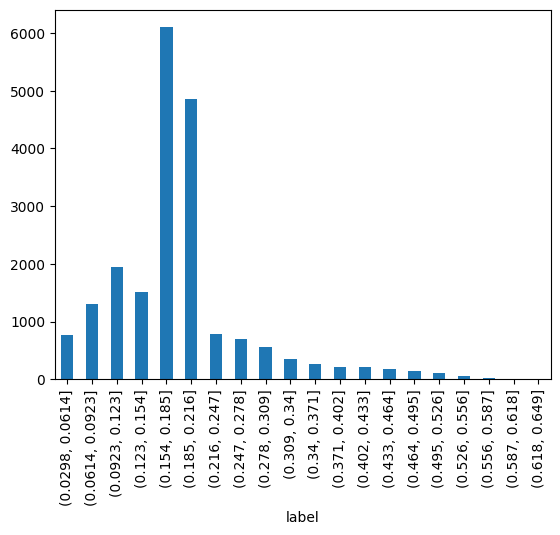

In [72]:
def stat_file_result(file_input):
    ret = pd.read_csv(file_input)
    df_ret = ret.groupby(pd.cut(ret['label'],bins=20))['label'].agg('count')
#     print(df_ret)
    df_ret.plot(kind='bar')
stat_file_result('202508261937_gh_lgb_kfold_v1.csv')


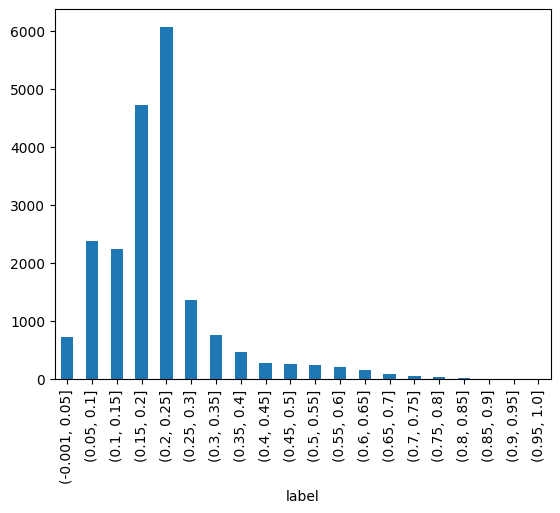

In [24]:
stat_file_result('202508261937_gh_v2.csv')

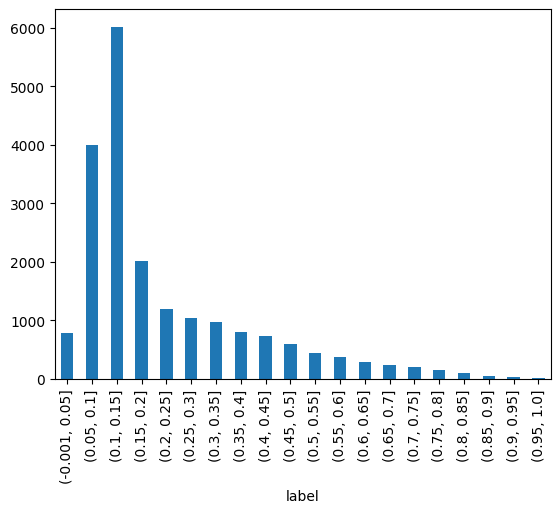

In [25]:
stat_file_result('202508261937_gh_lgb_v3.csv')